## Урок 6. Задача lookalike (Positive Unlabeled Learning)#

### Домашнее задание

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
6. применить random negative sampling для построения классификатора в новых условиях
7. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
8. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

### Кейс - определение ССЗ

Предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import QuantileTransformer

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('train_case2.csv', ';')
data.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [3]:
data.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


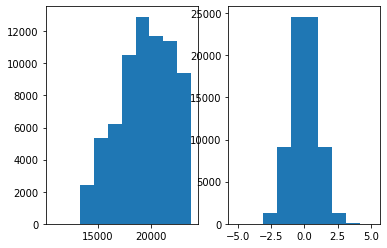

In [5]:
qt = QuantileTransformer(output_distribution='normal')

plt.subplot(1,2,1)
plt.hist(data['age'])

data['age'] = qt.fit_transform(data['age'].values.reshape(-1,1))
plt.subplot(1,2,2)
plt.hist(data['age'])

plt.show()

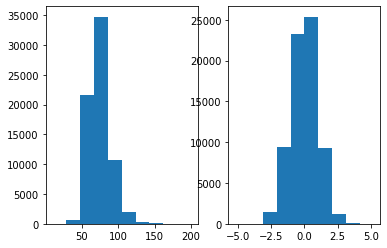

In [6]:
plt.subplot(1,2,1)
plt.hist(data['weight'])

data['weight'] = qt.fit_transform(data['weight'].values.reshape(-1,1))
plt.subplot(1,2,2)
plt.hist(data['weight'])

plt.show()

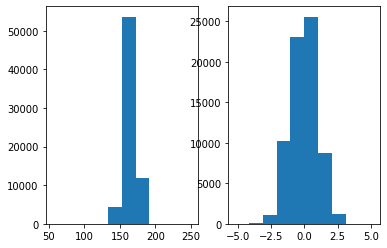

In [7]:
plt.subplot(1,2,1)
plt.hist(data['height'])

data['height'] = qt.fit_transform(data['height'].values.reshape(-1,1))
plt.subplot(1,2,2)
plt.hist(data['height'])

plt.show()

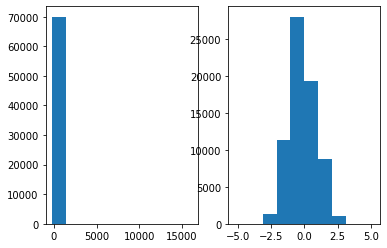

In [8]:
plt.subplot(1,2,1)
plt.hist(data['ap_hi'])

data['ap_hi'] = qt.fit_transform(data['ap_hi'].values.reshape(-1,1))
plt.subplot(1,2,2)
plt.hist(data['ap_hi'])

plt.show()

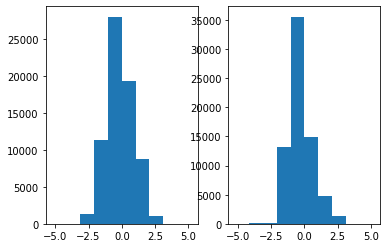

In [9]:
plt.subplot(1,2,1)
plt.hist(data['ap_hi'])

data['ap_lo'] = qt.fit_transform(data['ap_lo'].values.reshape(-1,1))
plt.subplot(1,2,2)
plt.hist(data['ap_lo'])

plt.show()

In [10]:
data = pd.get_dummies(data, columns = ['gender', 'cholesterol', 'gluc'])
data

,id,age,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,gender_1,gender_2,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
0,0,-0.417915,0.444534,-0.905189,-1.176890,-0.124523,0,0,1,0,0,1,1,0,0,1,0,0
1,1,0.153750,-1.066304,0.846279,0.809168,0.879040,0,0,1,1,1,0,0,0,1,1,0,0
2,2,-0.325577,0.084155,-0.738089,0.396560,-1.181921,0,0,0,1,1,0,0,0,1,1,0,0
3,3,-0.687303,0.590949,0.675277,1.255743,1.606755,0,0,1,1,0,1,1,0,0,1,0,0
4,4,-0.758562,-1.066304,-1.509656,-1.773922,-2.013671,0,0,0,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,-0.139405,0.444534,0.297918,-0.293986,-0.124523,1,0,1,0,0,1,1,0,0,1,0,0
69996,99995,1.244234,-0.798769,2.599253,0.809168,0.879040,0,0,1,1,1,0,0,1,0,0,1,0
69997,99996,-0.198898,2.256745,1.858747,2.307607,0.879040,0,1,0,1,0,1,0,0,1,1,0,0
69998,99998,1.109690,-0.189310,0.008782,0.584984,-0.124523,0,0,0,1,1,0,1,0,0,0,1,0


In [11]:
cols = data.columns.tolist()
cols

['id',
 'age',
 'height',
 'weight',
 'ap_hi',
 'ap_lo',
 'smoke',
 'alco',
 'active',
 'cardio',
 'gender_1',
 'gender_2',
 'cholesterol_1',
 'cholesterol_2',
 'cholesterol_3',
 'gluc_1',
 'gluc_2',
 'gluc_3']

In [12]:
data = data[['id',
 'age',
 'height',
 'weight',
 'ap_hi',
 'ap_lo',
 'smoke',
 'alco',
 'active',
 'gender_1',
 'gender_2',
 'cholesterol_1',
 'cholesterol_2',
 'cholesterol_3',
 'gluc_1',
 'gluc_2',
 'gluc_3', 'cardio']]

In [13]:
data.head()

,id,age,height,weight,ap_hi,ap_lo,smoke,alco,active,gender_1,gender_2,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3,cardio
0,0,-0.417915,0.444534,-0.905189,-1.176890,-0.124523,0,0,1,0,1,1,0,0,1,0,0,0
1,1,0.153750,-1.066304,0.846279,0.809168,0.879040,0,0,1,1,0,0,0,1,1,0,0,1
2,2,-0.325577,0.084155,-0.738089,0.396560,-1.181921,0,0,0,1,0,0,0,1,1,0,0,1
3,3,-0.687303,0.590949,0.675277,1.255743,1.606755,0,0,1,0,1,1,0,0,1,0,0,1
4,4,-0.758562,-1.066304,-1.509656,-1.773922,-2.013671,0,0,0,1,0,1,0,0,1,0,0,0


In [14]:
data.drop('id', 1)

,age,height,weight,ap_hi,ap_lo,smoke,alco,active,gender_1,gender_2,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3,cardio
0,-0.417915,0.444534,-0.905189,-1.176890,-0.124523,0,0,1,0,1,1,0,0,1,0,0,0
1,0.153750,-1.066304,0.846279,0.809168,0.879040,0,0,1,1,0,0,0,1,1,0,0,1
2,-0.325577,0.084155,-0.738089,0.396560,-1.181921,0,0,0,1,0,0,0,1,1,0,0,1
3,-0.687303,0.590949,0.675277,1.255743,1.606755,0,0,1,0,1,1,0,0,1,0,0,1
4,-0.758562,-1.066304,-1.509656,-1.773922,-2.013671,0,0,0,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,-0.139405,0.444534,0.297918,-0.293986,-0.124523,1,0,1,0,1,1,0,0,1,0,0,0
69996,1.244234,-0.798769,2.599253,0.809168,0.879040,0,0,1,1,0,0,1,0,0,1,0,1
69997,-0.198898,2.256745,1.858747,2.307607,0.879040,0,1,0,0,1,0,0,1,1,0,0,1
69998,1.109690,-0.189310,0.008782,0.584984,-0.124523,0,0,0,1,0,1,0,0,0,1,0,1


In [15]:
# Посмотрим на соотношение классов

data.iloc[:, -1].value_counts()

0    35021
1    34979
Name: cardio, dtype: int64

In [16]:
x_data = data.iloc[:,:-1]
y_data = data.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

In [17]:
classification_results = {
    'Pos Sample %' : [],
    'F-Score' : [],
    'Roc-Auc' : [],
    'Precision' : [],
    'Recall' : [],
}

In [18]:
model = GradientBoostingClassifier()

model.fit(x_train, y_train)
y_predict = model.predict(x_test)

In [19]:
def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 

    
evaluate_results(y_test, y_predict)

Classification results:
f1: 72.26%
roc: 73.46%
recall: 69.04%
precision: 75.80%


In [20]:
classification_results['Pos Sample %'].append(1)
classification_results['F-Score'].append(f1_score(y_test, y_predict))
classification_results['Roc-Auc'].append(roc_auc_score(y_test, y_predict))
classification_results['Precision'].append(precision_score(y_test, y_predict, average='binary'))
classification_results['Recall'].append(recall_score(y_test, y_predict, average='binary'))

In [21]:
pd.DataFrame(data=classification_results)

,Pos Sample %,F-Score,Roc-Auc,Precision,Recall
0,1,0.722633,0.734582,0.757984,0.690432


### PU learning

In [22]:
# Представим, что нам неизвестны негативы и часть позитивов

mod_data = data.copy()

#get the indices of the positives samples
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]

#shuffle them
np.random.shuffle(pos_ind)

# leave just 25% of the positives marked
pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))

print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')

pos_sample = pos_ind[:pos_sample_len]

Using 8745/34979 as positives and unlabeling the rest


In [23]:
# Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)

mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    61255
 1     8745
Name: class_test, dtype: int64


In [24]:
x_data = mod_data.iloc[:,:-2].values # just the X 
y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
y_positive = mod_data.iloc[:,-2].values # original class

### Random negative sampling

In [25]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
print(sample_test.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(8745, 19) (8745, 19)
(52510, 19)


In [26]:
model = GradientBoostingClassifier()

model.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)
y_predict = model.predict(sample_test.iloc[:,:-2].values)
evaluate_results(sample_test.iloc[:,-2].values, y_predict)

Classification results:
f1: 68.20%
roc: 67.46%
recall: 89.25%
precision: 55.19%


In [27]:
classification_results['Pos Sample %'].append(0.25)
classification_results['F-Score'].append(f1_score(sample_test.iloc[:,-2].values, y_predict))
classification_results['Roc-Auc'].append(roc_auc_score(sample_test.iloc[:,-2].values, y_predict))
classification_results['Precision'].append(precision_score(sample_test.iloc[:,-2].values, y_predict, average='binary'))
classification_results['Recall'].append(recall_score(sample_test.iloc[:,-2].values, y_predict, average='binary'))

In [28]:
pd.DataFrame(data=classification_results)

,Pos Sample %,F-Score,Roc-Auc,Precision,Recall
0,1.00,0.722633,0.734582,0.757984,0.690432
1,0.25,0.682042,0.674637,0.551891,0.892524


Метрики roc и f-score PU модели несколько хуже, чем изначальные результаты, но в целом результат не такой уж и плохой.
Полнота оказалась более высокой у PU модели, но это сказывается на точности, она значительно уменьшилась по сравнению с первоначальным результатом.

In [29]:
pos_sample_percentage = [0.1, 0.4, 0.7, 0.9]

for percentage in pos_sample_percentage:
    
    mod_data = data.copy()

    #get the indices of the positives samples
    pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]

    #shuffle them
    np.random.shuffle(pos_ind)

    # leave just % of the positives marked
    pos_sample_len = int(np.ceil(percentage * len(pos_ind)))

    print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
    pos_sample = pos_ind[:pos_sample_len]
    
    mod_data['class_test'] = -1
    mod_data.loc[pos_sample,'class_test'] = 1
    print('target variable:\n', mod_data.iloc[:,-1].value_counts())
    
    x_data = mod_data.iloc[:,:-2].values # just the X 
    y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
    y_positive = mod_data.iloc[:,-2].values # original class
    
    mod_data = mod_data.sample(frac=1)
    neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
    sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
    pos_sample = mod_data[mod_data['class_test']==1]
    print(neg_sample.shape, pos_sample.shape)
    sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)
    
    model = GradientBoostingClassifier()
    model.fit(sample_train.iloc[:,:-2].values, sample_train.iloc[:,-2].values)
    y_predict = model.predict(sample_test.iloc[:,:-2].values)
    
    evaluate_results(sample_test.iloc[:,-2].values, y_predict)
    
    classification_results['Pos Sample %'].append(percentage)
    classification_results['F-Score'].append(f1_score(sample_test.iloc[:,-2].values, y_predict))
    classification_results['Roc-Auc'].append(roc_auc_score(sample_test.iloc[:,-2].values, y_predict))
    classification_results['Precision'].append(precision_score(sample_test.iloc[:,-2].values, y_predict, average='binary'))
    classification_results['Recall'].append(recall_score(sample_test.iloc[:,-2].values, y_predict, average='binary'))

Using 3498/34979 as positives and unlabeling the rest
target variable:
 -1    66502
 1     3498
Name: class_test, dtype: int64
(3498, 19) (3498, 19)
Classification results:
f1: 70.59%
roc: 65.33%
recall: 91.35%
precision: 57.51%
Using 13992/34979 as positives and unlabeling the rest
target variable:
 -1    56008
 1    13992
Name: class_test, dtype: int64
(13992, 19) (13992, 19)
Classification results:
f1: 64.43%
roc: 68.63%
recall: 87.48%
precision: 50.99%
Using 24486/34979 as positives and unlabeling the rest
target variable:
 -1    45514
 1    24486
Name: class_test, dtype: int64
(24486, 19) (24486, 19)
Classification results:
f1: 53.45%
roc: 72.34%
recall: 79.85%
precision: 40.17%
Using 31482/34979 as positives and unlabeling the rest
target variable:
 -1    38518
 1    31482
Name: class_test, dtype: int64
(31482, 19) (31482, 19)
Classification results:
f1: 34.53%
roc: 73.50%
recall: 73.31%
precision: 22.59%


In [30]:
pd.DataFrame(data=classification_results)

,Pos Sample %,F-Score,Roc-Auc,Precision,Recall
0,1.00,0.722633,0.734582,0.757984,0.690432
1,0.25,0.682042,0.674637,0.551891,0.892524
2,0.10,0.705872,0.653311,0.575128,0.913549
3,0.40,0.644293,0.686277,0.509923,0.874817
4,0.70,0.534496,0.723443,0.401699,0.798458
5,0.90,0.345339,0.734992,0.225866,0.733133


Как ни странно, при P больше 0.4 сильно уменьшается точность, а также уменьшается f-score, полнота остается хорошей, даже выше, чем у изначальной модели. Так доконца и не разобралась, почему так происходит. Может быть, при увеличении P и уменьшении объема тестовой выборки, тестовая выборка оказывается несбалансированной по тем или иным признакам?